## imports

In [1]:
import os
import imageio
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
cudnn.benchmark = True

import pytorch3d
import pytorch3d.io


# some utility function for visualization
import utils
from utils.util_3d import init_mesh_renderer, sdf_to_mesh, add_mesh_textures

# some utility function
from utils.qual_util import save_mesh_as_gif
from IPython.display import Image as ipy_image
from IPython.display import display

%reload_ext autoreload
%autoreload 2

In [2]:
from utils.demo_util import get_shape_comp_opt
from utils.demo_util import get_shape_comp_model

""" setup dir """
res_dir = 'results'
if not os.path.exists(res_dir): os.mkdir(res_dir)

""" setup opt"""
gpu_id = 0

opt = get_shape_comp_opt(gpu_id=gpu_id)

""" setup different model """
model = get_shape_comp_model(opt)    
model.eval()

""" setup renderer """
dist, elev, azim = 1.7, 20, 110
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)

jvermandere
gpuserver-1.geomatics.kuleuven.be
[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: saved_ckpt/pvqvae-snet-all-LR1e-4-T0.2-rerun-epoch140.pth
[*] Model has been created: Rand-Transformer-Model
[*] "rand_tf" initialized.
[*] weight successfully load from: saved_ckpt/rand_tf-snet_code-all-LR1e-4-clean-epoch200.pth


# Shape Completion
1. Unconditional generation
2. Structured input (e.g., given a leg of a chair)

## Unconditional

In [ ]:
""" Shape completion 1 - unconditional generation """
gen_sdf = model.uncond_gen(bs=9, topk=31)
gen_sdf_as_mesh = sdf_to_mesh(gen_sdf)

# save as gif
gif_name = f'{res_dir}/shape-comp-uncond.gif'
save_mesh_as_gif(mesh_renderer, gen_sdf_as_mesh, nrow=3, out_name=gif_name)

ipy_image(gif_name)

In [ ]:
"""
    Shape completion 2 - structured input
     - given a mesh, we first extract SDF from that mesh.
     - then user can specify the partial input by setting the min & max values of x, y, z.
"""
import utils
from utils.qual_util import get_partial_shape_by_range
from preprocess.process_one_mesh import process_obj

# input: complete chair
# first extract sdf from mesh
obj_file = 'demo_data/chair_model.obj'
sdf_file = process_obj(obj_file)


In [ ]:

sdf = utils.util_3d.read_sdf(sdf_file).to(opt.device)


## From File

In [5]:
from utils.qual_util import get_partial_shape_by_range
#sdf = model.uncond_gen(bs=1, topk=31)
sdf = torch.load('../../datasets/Paper_examples/UnderTableChair.pt',map_location=torch.device('cuda'))
gen_sdf_as_mesh = sdf_to_mesh(sdf)
print (sdf)


tensor([[[[[0.6512, 0.6337, 0.6173,  ..., 1.5217, 1.5503, 1.5789],
           [0.6493, 0.6317, 0.6153,  ..., 1.5220, 1.5506, 1.5792],
           [0.6485, 0.6310, 0.6145,  ..., 1.5221, 1.5505, 1.5791],
           ...,
           [0.5088, 0.4962, 0.4852,  ..., 1.5784, 1.6067, 1.6352],
           [0.5079, 0.4952, 0.4842,  ..., 1.5867, 1.6149, 1.6433],
           [0.5088, 0.4962, 0.4852,  ..., 1.5956, 1.6237, 1.6518]],

          [[0.6260, 0.6078, 0.5907,  ..., 1.5092, 1.5379, 1.5668],
           [0.6241, 0.6058, 0.5886,  ..., 1.5095, 1.5382, 1.5671],
           [0.6233, 0.6050, 0.5878,  ..., 1.5095, 1.5382, 1.5670],
           ...,
           [0.4809, 0.4675, 0.4558,  ..., 1.5681, 1.5967, 1.6253],
           [0.4798, 0.4664, 0.4548,  ..., 1.5765, 1.6049, 1.6334],
           [0.4809, 0.4675, 0.4558,  ..., 1.5855, 1.6137, 1.6421]],

          [[0.6014, 0.5824, 0.5645,  ..., 1.4971, 1.5262, 1.5552],
           [0.5994, 0.5804, 0.5625,  ..., 1.4974, 1.5264, 1.5555],
           [0.5986, 0.5796

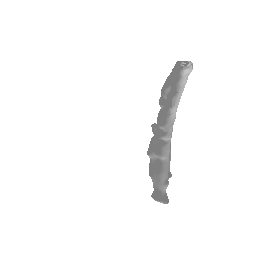

In [6]:
# save as gif
gif_name = f'{res_dir}/shape-example.gif'
save_mesh_as_gif(mesh_renderer, gen_sdf_as_mesh, nrow=1, out_name=gif_name)
ipy_image(gif_name)


In [ ]:
#print(sdf)
torch.save(sdf, 'demo_data/tensor.txt')

In [16]:

# range: -1 ~ 1.
# x: left-to-right; y: bottom-to-top; z: front-to-back
# example: only conditioning on the bottom of the chair
min_x, max_x = -1., 1.
min_y, max_y = -1., 1.
min_z, max_z = -1, -0.5
input_range = {'x1': min_x, 'x2': max_x, 'y1': min_y, 'y2': max_y, 'z1': min_z, 'z2': max_z}

shape_comp_input = get_partial_shape_by_range(sdf, input_range)

[*] autoregressively inferencing...:   0%|          | 0/384 [00:00<?, ?it/s]

[*] autoregressively inferencing...: 100%|██████████| 384/384 [00:14<00:00, 26.66it/s]


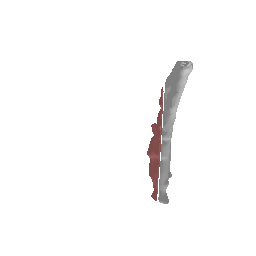

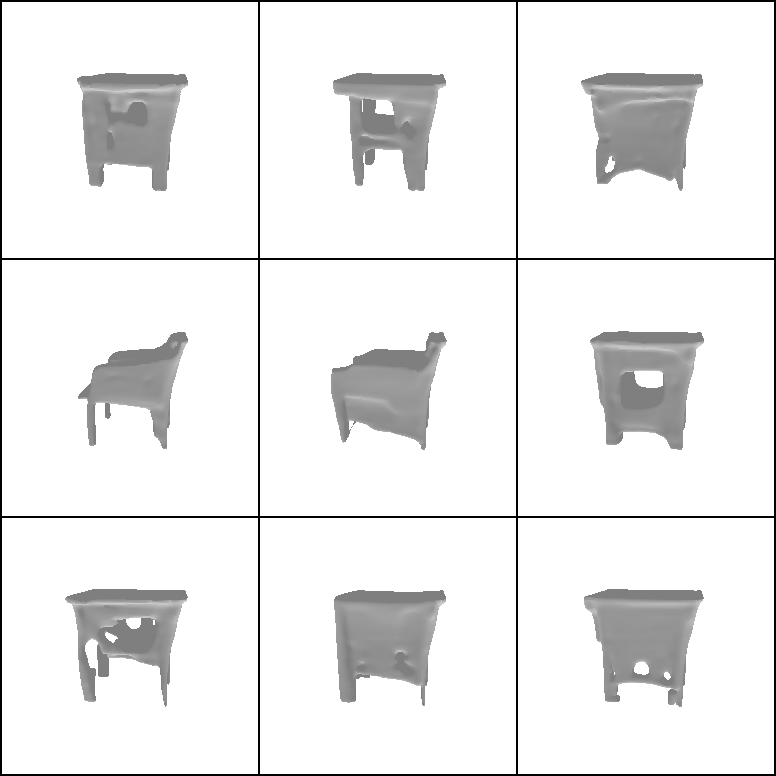

In [17]:
""" perform shape completion """
input_mesh, comp_sdf = model.shape_comp(shape_comp_input, bs=9, topk=30)

gen_mesh = sdf_to_mesh(comp_sdf)          # completed shape

# save as gif
gif_name = f'{res_dir}/shape-comp-struct-input-inp.gif'
save_mesh_as_gif(mesh_renderer, input_mesh, nrow=1, out_name=gif_name)

gen_gif_name = f'{res_dir}/shape-comp-struct-input-gen.gif'
save_mesh_as_gif(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)

for name in [gif_name, gen_gif_name]:
    display(ipy_image(name))

## Save the meshes

In [31]:
i=0
for mesh in gen_mesh:
    final_verts, final_faces = mesh.get_mesh_verts_faces(0)
    pytorch3d.io.save_obj("../../datasets/Paper_examples/UnderTableChair_completed_" + str(i) + ".obj", final_verts, final_faces)
    i+=1